In [9]:
import torch
import numpy
import matplotlib.pyplot as plt

from dataset_mnist import *
from augmentations import *
from cnn_model_b     import *
from umap_projection import *


## dataset

sample random batch x, y = dataset.get_batch(batch_size),

x input with shape (batch_size, 1, 28, 28)

y labels with shape (batch_size, ) (not used)

execute two sets of augmentation and plot augmented example

## augmentations

aditive gaussian noise

random color inversion (negative)

random pixel zeroing

x =  torch.Size([256, 1, 28, 28]) tensor(0.1307) tensor(0.3079) tensor(1.)


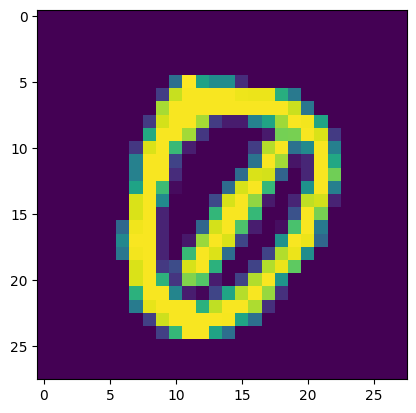

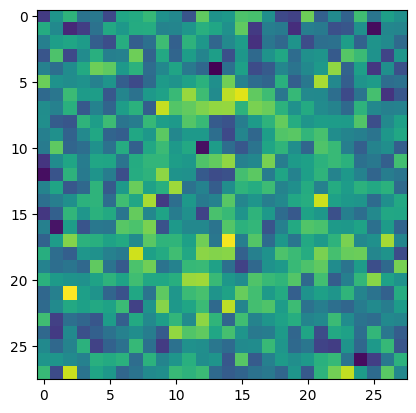

noise level =  tensor([[0.3934],
        [0.0643],
        [0.3605],
        [0.0434],
        [0.1082],
        [0.0552],
        [0.2982],
        [0.3406],
        [0.3602],
        [0.4611],
        [0.0180],
        [0.3371],
        [0.2619],
        [0.1087],
        [0.3961],
        [0.0094],
        [0.4186],
        [0.0914],
        [0.1744],
        [0.2950],
        [0.4528],
        [0.3085],
        [0.2017],
        [0.1221],
        [0.4110],
        [0.2803],
        [0.4470],
        [0.2908],
        [0.4252],
        [0.2572],
        [0.0894],
        [0.0564],
        [0.3018],
        [0.0023],
        [0.2831],
        [0.3733],
        [0.0870],
        [0.0522],
        [0.0291],
        [0.3539],
        [0.2018],
        [0.4893],
        [0.1455],
        [0.0016],
        [0.2322],
        [0.4287],
        [0.3067],
        [0.2391],
        [0.0469],
        [0.2408],
        [0.0616],
        [0.3464],
        [0.3645],
        [0.1576],
        [0.23

In [10]:
dataset = DatasetMnist()
batch_size = 256    

x, y = dataset.get_batch(batch_size)

print("x = ", x.shape, x.mean(), x.std(), x.max())

x_orig   = x
    
#add noise
x_noised, alpha = aug_noise(x_orig)

plt.imshow(x[0][0].detach().cpu().numpy())
plt.show()
plt.imshow(x_noised[0][0].detach().cpu().numpy())
plt.show()

print("noise level = ", alpha)


## vicreg loss - non contrastive self supervised loss

- similarity, sim_loss : makes same inputs close
- variance, std_za, std_za : batch-wise variance, prevent collapsing, forces model to generate unique features for every different input
- covariance, cov_za, cov_zb : element-wise (feature-wise) decorrelation, forces model to generate unique features - output from model within single input are not correlate, a.k.a : each features output (each of 256 signals) gives unique infomation


In [11]:
def _off_diagonal(x):
    mask = 1.0 - torch.eye(x.shape[0], device=x.device)
    return x*mask 

def vicreg_loss_func_noise(za, zb): 
    # invariance loss
    sim_loss = ((za - zb)**2).mean()

    # variance loss
    std_za = torch.sqrt(za.var(dim=0) + 1e-6)
    std_zb = torch.sqrt(zb.var(dim=0) + 1e-6) 
    
    std_loss = torch.mean(torch.relu(1.0 - std_za)) 
    std_loss+= torch.mean(torch.relu(1.0 - std_zb))
   
    # covariance loss 
    za_norm = za - za.mean(dim=0)
    zb_norm = zb - zb.mean(dim=0)
    cov_za = (za_norm.T @ za_norm) / (za.shape[0] - 1.0)
    cov_zb = (zb_norm.T @ zb_norm) / (zb.shape[0] - 1.0)
    
    cov_loss = _off_diagonal(cov_za).pow_(2).sum()/za.shape[1] 
    cov_loss+= _off_diagonal(cov_zb).pow_(2).sum()/zb.shape[1]

    # total vicreg loss
    loss = 1.0*sim_loss + 1.0*std_loss + (1.0/25.0)*cov_loss

    return loss










## training loop

In [12]:
n_features = 128    

loss_functions = [vicreg_loss_func_noise]


# train by all loss functions in lsit
for loss_func in loss_functions:
    # create model and optimizer
    model     = Model(dataset.input_shape, n_features)
    print("\n\n")
    print("starting training with loss ", loss_func)
    print(model)


    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    steps_count = len(dataset)//batch_size
    for i in range(steps_count):

        #get random batch
        xa, _      = dataset.get_batch(batch_size)
        xa_noised, alpha_a  = aug_noise(xa)

        xb, _      = dataset.get_batch(batch_size)
        xb_noised, alpha_b  = aug_noise(xb)

        xa = torch.concatenate([xa, xa_noised], dim=0)
        xb = torch.concatenate([xb, xb_noised], dim=0)

        alpha_a = torch.concatenate([torch.zeros_like(alpha_a), alpha_a], dim=0)
        alpha_b = torch.concatenate([torch.zeros_like(alpha_b), alpha_b], dim=0)

        #obtain features
        za, alpha_a_pred = model(xa)
        zb, alpha_b_pred = model(xb)
        
        #compute loss
        loss_ssl = loss_func(za, zb)

        #noise level prediciton MSE loss
        loss_noise_level = ((alpha_a - alpha_a_pred)**2).mean()
        loss_noise_level+= ((alpha_b - alpha_b_pred)**2).mean()


        loss = loss_ssl + loss_noise_level

        #optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        print(i, steps_count, loss) 

    result_name = str(loss_func.__name__)
    torch.save(model.state_dict(), "trained/" + result_name + ".pt")


print("training done")





starting training with loss  <function vicreg_loss_func_noise at 0x317ec1a60>
Model(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): SiLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): SiLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): SiLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=6272, out_features=128, bias=True)
  )
  (model_noise_pred): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)
0 234 tensor(2.0798, grad_fn=<AddBackward0>)
1 234 tensor(2.0825, grad_fn=<AddBackward0>)
2 234 tensor(2.0802, grad_fn=<AddBackward0>)
3 234 tensor(2.0709, grad

## features projection

2D visualisation of trained feature space

sample random batch
use UMAP and T-SNE to project 128D space into 2D
plot it, with coloring by class ID

Model(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): SiLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): SiLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): SiLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): SiLU()
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=6272, out_features=128, bias=True)
  )
  (model_noise_pred): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): SiLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=1, bias=True)
  )
)


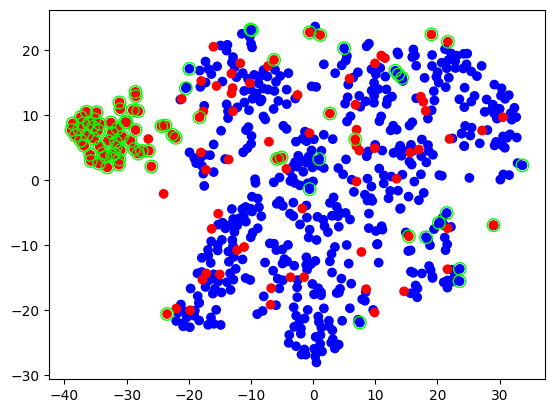

In [13]:
from anomaly_detection import *
from sklearn.manifold import TSNE

batch_size  = 512   

result_name = str(loss_functions[0].__name__)

model = Model(dataset.input_shape, n_features)

model.load_state_dict(torch.load("trained/" + result_name + ".pt", map_location = "cpu"))

print(model)

# sample batch
x_normal, _ = dataset.get_batch(batch_size)

# sample smaller batch
x_anomaly, _ = dataset.get_batch(batch_size//4)
x_anomaly, _  = aug_noise(x_anomaly.clone())

# concatenate into single batch
x = torch.concatenate([x_normal, x_anomaly], dim=0)
y = torch.concatenate([torch.zeros((x_normal.shape[0], )), torch.ones((x_anomaly.shape[0], ))], dim=0)


y = y.detach().cpu().numpy()
y = numpy.array(y, dtype=int)


# obtain fetures
z, _ = model(x) 
dist = torch.cdist(z, z)
z = z.detach().cpu().numpy()


# fit and transform the data to reduce to 2 dimensions
z_proj = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(z)

# detect anomalies
anomaly_indices, _ = z_score_anomaly_detection(z, 1)

# plot 2D projections, anomalies red, detected lime color
colormap = numpy.array(["blue", "red"])
plt.scatter(z_proj[:, 0], z_proj[:, 1], c=colormap[y])
plt.scatter(z_proj[anomaly_indices, 0], z_proj[anomaly_indices, 1], s=81, facecolors='none', edgecolors="lime")
plt.show()

